In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import yaml
import sys 
sys.path.append('..')

from ptsemseg.loader import get_loader
from ptsemseg.loader import get_loader
from ptsemseg.models import get_model
from ptsemseg.utils import get_model_state
import matplotlib.pyplot as plt
import matplotlib
import patch_utils as patch_utils
from torch.utils import data
import numpy as np
from torch import nn
from PIL import Image
import torch
import os

from IPython.display import display # to display images

print('torch version:       {}'.format(torch.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

torch version:       2.5.1+cu118
numpy version:       1.23.5
matplotlib version:  3.10.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            4


## ------------------------------------------------------------------------------------------------------------
# Example of the dataset construction and configuration  
In this part, we load the dataset with the chosen configuration and apply the selected spatial perturbations.  
Each image is divided into patches, and a subset of them is corrupted according to the specified perturbation type and severity.  
The following example shows one sample image from the validation set after the perturbations have been applied.  

In [ ]:
# ---------------------------------------------------------------
# Configuration and device setup
# ---------------------------------------------------------------

config_path = 'configs/loader_config.yml'
GPU_DEVICE = 2

# Load configuration file
with open(config_path) as fp:
    cfg = yaml.load(fp)

# Extract model name from config path for logging/evaluation
model_file_name = os.path.split(cfg["model"]["path"])[1]
model_name = model_file_name[: model_file_name.find("_")]

# Define CUDA device
device = torch.device("cuda")
torch.cuda.set_device(GPU_DEVICE)

# ---------------------------------------------------------------
# Dataset and augmentation settings
# ---------------------------------------------------------------

# Load dataset interface
data_loader = get_loader(cfg["data"]["dataset"])
data_path = cfg["data"]["path"]

# Define corruption/augmentation parameters for spatial robustness evaluation
augmentation = {  
        "patch_size": [256, 256],       # Size of patches into which each image is divided
        "perturbation_ratio": 0.5,      # Fraction of patches to perturb (e.g., 0.5 = 50%)
        "perturbation_type": ["Snow"],  # Type(s) of corruption to apply
        "allow_mixed_perturbations": False,  # If True, multiple perturbations can overlap in the same patch
        "severity_level": 1             # Intensity of corruption (e.g., scale 1–5)
    }

# ---------------------------------------------------------------
# Training and validation datasets with augmentations
# ---------------------------------------------------------------

train_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["train_split"],
    version=cfg["data"]["version"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_norm=cfg["data"]["img_norm"],
    bgr=cfg["data"]["bgr"],
    std_version=cfg["data"]["std_version"],
    augmentation_params=augmentation
)

validation_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["val_split"],
    version=cfg["data"]["version"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_norm=cfg["data"]["img_norm"],
    bgr=cfg["data"]["bgr"], 
    std_version=cfg["data"]["std_version"],
    bottom_crop=0,
    augmentation_params=augmentation
)

# Number of classes in the segmentation dataset
n_classes = train_loader.n_classes

# ---------------------------------------------------------------
# DataLoaders
# ---------------------------------------------------------------

BATCH_SIZE = 8

validationloader = data.DataLoader(
    validation_loader, 
    batch_size=BATCH_SIZE, 
    num_workers=cfg["device"]["n_workers"],
    shuffle=False
)

trainloader = data.DataLoader(
    train_loader, 
    batch_size=4,  # Smaller batch size for training if resources are limited
    num_workers=cfg["device"]["n_workers"],
    shuffle=False
)


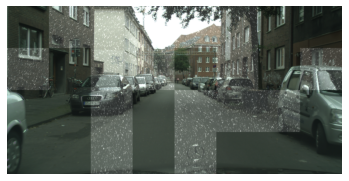

In [3]:
# ---------------------------------------------------------------
# Quick visualization of a sample image from the validation set
# ---------------------------------------------------------------

plt.axis('off')  
imm = validationloader.dataset[9][0]
imm = torch.tensor(imm).float().unsqueeze(0).to(device)
plt.imshow(patch_utils.convert_tensor_image(imm, set_loader=train_loader))

## ------------------------------------------------------------------------------------------------------------

# Natural robustness evaluation of SS Models

In this section, we evaluate how segmentation models degrade under natural perturbations.  
For each corruption ratio $ r $ (fraction of image patches perturbed), we measure the drop in performance between the clean dataset $ \mathcal{D}_{\text{clean}} $ and the corrupted dataset $\mathcal{D}_{\text{corr}}(r) $.  

The robustness gap is defined as:  

$$
\Delta(r) = \text{mIoU}(f, \mathcal{D}_{\text{clean}}) - \text{mIoU}(f, \mathcal{D}_{\text{corr}}(r))
$$

where $ f $ is the segmentation model.  

We separately analyze regions of the image:
- **normal**: entire image  
- **spatial**: uncorrupted area  
- **local**: corrupted area  



In [29]:
from eval import validate_spatial
import random
import numpy as np
import torch

# ---------------------------------------------------------------
# Models to evaluate (uncomment to include more)
# ---------------------------------------------------------------
name_dict = [
    'bisenetX39',
    'bisenetR18',
    # 'bisenetR101',
    # 'ddrnet23',
    # 'ddrnet23Slim',
    # 'mask2former_large',
    'segformer_bo',
    # 'segformer_b1',
    # 'segformer_b5',
    # 'deeplabv3_mobilenet',
    # 'deeplabv3_resnet',
    # 'pidnet_s',
    # 'pidnet_m',
    # 'pidnet_l',
]

# ---------------------------------------------------------------
# Reproducibility, reset RNG state before each model's evaluation
# ---------------------------------------------------------------
def reset_seed(seed: int):
    """Reset numpy, random, and torch seeds for reproducible evaluation."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Optional (determinism vs. speed):
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


# Patch-perturbation ratios to sweep (fraction of image patches corrupted)
ratio = [0.1, 0.25, 0.5, 0.8]

import models_utils
results_snow_ratio = {}

for r in ratio:
    # -----------------------------------------------------------
    # Configure the corruption for this sweep value r
    # -----------------------------------------------------------
    augmentation = {
        "patch_size": [128, 128],     # Patch width and height
        "perturbation_ratio": r,      # Fraction of patches to corrupt
        "perturbation_type": ["Snow"],# Corruption type(s)
        "allow_mixed_perturbations": False,  # If True, allow multiple types per patch
        "severity_level": 5           # Corruption intensity (1–5)
    }

    # Build the validation dataset with the current corruption settings
    validation_loader = data_loader(
        data_path,
        is_transform=True,
        split=cfg["data"]["val_split"],
        version=cfg["data"]["version"],
        img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
        img_norm=cfg["data"]["img_norm"],
        bgr=cfg["data"]["bgr"],
        std_version=cfg["data"]["std_version"],
        bottom_crop=0,
        augmentation_params=augmentation
    )

    # Wrap into a DataLoader (no shuffle for evaluation)
    BATCH_SIZE = 4
    validationloader = data.DataLoader(
        validation_loader,
        batch_size=BATCH_SIZE,
        num_workers=cfg["device"]["n_workers"],
        shuffle=False
    )

    # -----------------------------------------------------------
    # Evaluate each model and store results for this ratio r
    # -----------------------------------------------------------
    results_snow_ratio[str(r)] = {}
    for i, name in enumerate(name_dict):
        model, name = models_utils.load_model_with_weights(name)
        model = model.to('cuda')
        reset_seed(42)  # Ensure reproducible sampling/ops per model
        result = validate_spatial(model, validationloader, device, test_mode=True, model_name=name)
        results_snow_ratio[str(r)][name] = result

        # Free GPU memory between models
        del model
        torch.cuda.empty_cache()


Found 500 val images

Using ImageNet data
bisenetX39
bisenetR18


/home/g.rossolini/venv/gtorch/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


Found 500 val images

Using ImageNet data
bisenetX39
bisenetR18
Found 500 val images

Using ImageNet data
bisenetX39
bisenetR18
Found 500 val images

Using ImageNet data
bisenetX39
bisenetR18


<Figure size 1440x1008 with 0 Axes>

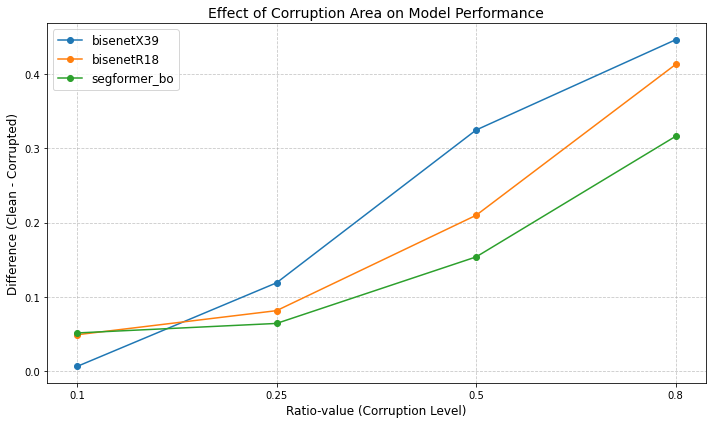

In [30]:
# ---------------------------------------------------------------
# Understanding the results dictionary
# ---------------------------------------------------------------
"""
The results dictionary has the following structure:

    results[ratio][model][region][condition]

- Regions:
    - "normal"   → metrics computed over the entire image
    - "spatial"  → metrics on the uncorrupted (clean) area
    - "local"    → metrics on the corrupted area only

- Conditions:
    - "clean"     → evaluation on the original (non-corrupted) image
    - "corrupted" → evaluation on the perturbed image

Example:
    results[r][model]["spatial"]["clean"]
returns the scores for the spatial (uncorrupted) area on the clean dataset.
"""

# ---------------------------------------------------------------
# Prepare data for plotting robustness drop vs corruption ratio
# ---------------------------------------------------------------

# Extract corruption ratios (r-values) and list of tested models
r_values = sorted(results_snow_ratio.keys())
models = list(results_snow_ratio[r_values[0]].keys())

# Initialize dictionary to store per-model differences
model_differences = {model: [] for model in models}

# Compute the performance drop (clean − corrupted) for each ratio and model
for r in r_values:
    for model in models:
        clean = results_snow_ratio[r][model]["spatial"]["clean"].get_scores()[0]['Mean IoU : \t']
        corrupted = results_snow_ratio[r][model]["spatial"]["corrupted"].get_scores()[0]['Mean IoU : \t']
        difference = clean - corrupted
        model_differences[model].append(difference)

# ---------------------------------------------------------------
# Plot the robustness drop across corruption ratios
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot each model’s degradation curve
for model, differences in model_differences.items():
    plt.plot(r_values, differences, marker="o", label=model)

# Add labels, title, and legend
plt.xlabel("Corruption Ratio (fraction of patches perturbed)", fontsize=12)
plt.ylabel("Performance Drop (Clean − Corrupted mIoU)", fontsize=12)
plt.title("Effect of Corruption Area on Model Performance", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Display plot
plt.tight_layout()
plt.show()


## ------------------------------------------------------------------------------------------------------------

# Adversarial robustness evaluation  

In this section, we compare model performance on clean and adversarially perturbed inputs.  
For each model, we report the mean Intersection-over-Union (mIoU), where the bar plot shows both values side by side, and the difference highlights the robustness gap in the not-attacked region:.


In [ ]:
from eval import validate_spatial
from eval import eval_attacks
import random

# ---------------------------------------------------------------
# Models to evaluate (uncomment to include more)
# ---------------------------------------------------------------
name_dict = [
    'bisenetX39',
    # 'bisenetR18',
    # 'bisenetR101',
    'ddrnet23',
    # 'ddrnet23Slim',
    # 'mask2former_large',
    'segformer_bo',
    # 'segformer_b1',
    # 'segformer_b5',
    # 'deeplabv3_mobilenet',
    # 'deeplabv3_resnet',
    # 'pidnet_s',
    # 'pidnet_m',
    # 'pidnet_l',
]

# ---------------------------------------------------------------
# Dataset for adversarial analysis
# ---------------------------------------------------------------
# For adversarial evaluation, no natural augmentations are applied.
# (Note: adversarial and natural corruptions could be combined if desired.)
augmentation = None

validation_loader = data_loader(
    data_path,
    is_transform=True,
    split=cfg["data"]["val_split"],
    version=cfg["data"]["version"],
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
    img_norm=cfg["data"]["img_norm"],
    bgr=cfg["data"]["bgr"], 
    std_version=cfg["data"]["std_version"],
    bottom_crop=0,
    augmentation_params=augmentation
)

# ---------------------------------------------------------------
# Attack configuration
# ---------------------------------------------------------------
attack_size = (128, 128)       # Size of the adversarial patch
attack_position = 'center'     # Position where the patch is applied
attack_type = 'pgd_distance_based'  # Attack method (simple pgd attack on distance, for ripetitve analysis look at eval_attacks.py script)

# Normalization parameters (example: ImageNet)
mean = [0.485, 0.456, 0.40]
std = [0.229, 0.224, 0.225]

# PGD parameters
epsilon = 64/255   # Maximum perturbation (L∞ norm bound)
alpha = 4/255      # Step size
num_steps = 100    # Number of PGD iterations

# Validation loader
BATCH_SIZE = 4
validationloader = data.DataLoader(
    validation_loader, 
    batch_size=BATCH_SIZE, 
    num_workers=cfg["device"]["n_workers"],
    shuffle=False
)

# ---------------------------------------------------------------
# reproducibility
# ---------------------------------------------------------------
def reset_seed(seed: int):
    """Reset numpy and random seeds (PyTorch optional)."""
    np.random.seed(seed)
    random.seed(seed)



# ---------------------------------------------------------------
# Run adversarial evaluation
# ---------------------------------------------------------------
import models_utils
results_snow = {}

for i, name in enumerate(name_dict): 
    model, name = models_utils.load_model_with_weights(name)
    model = model.to('cuda')

    reset_seed(42)  # Ensure reproducibility

    # Run adversarial attack on the validation set
    # For full evaluation set test_mode=False
    result = eval_attacks(
        model, validationloader, device, test_mode=True,
        attack_type=attack_type, mean=mean, std=std,
        epsilon=epsilon, alpha=alpha, num_steps=num_steps,
        attack_position='left_corner', attack_size=attack_size,
        batch_size=4, model_name=name
    )

    results_snow[name] = result

    # Free GPU memory before next model
    del model
    torch.cuda.empty_cache()


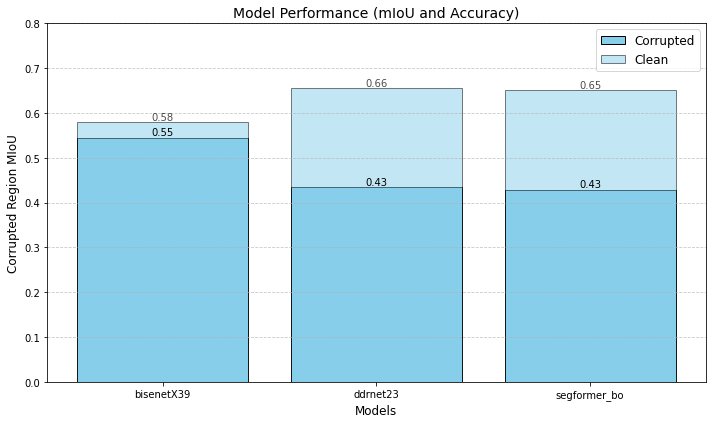

In [36]:
# ---------------------------------------------------------------
# Extract results for plotting (per-model mIoU)
# ---------------------------------------------------------------

models = list(results_snow.keys())

# mIoU in the non-corrupted (spatial) ,attacked images (corrupted)
miou_values = [
    results_snow[m]['spatial']['corrupted'].get_scores()[0]['Mean IoU : \t']
    for m in models
]

# mIoU in the non-corrupted (spatial) , not-attacked images (clean)
accuracy_values = [
    results_snow[m]['spatial']['clean'].get_scores()[0]['Mean IoU : \t']
    for m in models
]

# ---------------------------------------------------------------
# Create bar plot comparing clean vs. corrupted mIoU
# ---------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot corrupted mIoU as solid bars
bars_miou = plt.bar(models, miou_values, color="skyblue", edgecolor="black", label="Corrupted")

# Overlay clean mIoU as transparent bars
bars_accuracy = plt.bar(
    models, accuracy_values, color="skyblue", edgecolor="black",
    alpha=0.5, label="Clean"
)

# ---------------------------------------------------------------
# Annotate bars with numeric values
# ---------------------------------------------------------------
for bar_miou, bar_acc in zip(bars_miou, bars_accuracy):
    yval_miou = bar_miou.get_height()
    yval_acc = bar_acc.get_height()
    plt.text(bar_miou.get_x() + bar_miou.get_width() / 2, yval_miou, f"{yval_miou:.2f}",
             ha="center", va="bottom", fontsize=10)
    plt.text(bar_acc.get_x() + bar_acc.get_width() / 2, yval_acc, f"{yval_acc:.2f}",
             ha="center", va="bottom", fontsize=10, alpha=0.7)

# ---------------------------------------------------------------
# Final plot formatting
# ---------------------------------------------------------------
plt.ylabel("mIoU (spatial region)", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.title("Model Performance Under Adversarial Perturbation", fontsize=14)
plt.ylim(0, 0.8)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
